In [ ]:
# 1. Clone the nmrlipids repo (Databank)
!git clone https://github.com/batukav/Databank.git

# Change directory to the cloned Databank repo
%cd Databank

# 2. Clone the BilayerData into the Databank repo
!git clone https://github.com/NMRLipids/BilayerData.git

# 3. Install the requirements
# This installs the current directory (Databank) as a package
!pip install .


In [ ]:
import os

# Get the current working directory (should be /content/Databank)
cwd = os.getcwd()

# 4. Set the FMDL_DATA_PATH to the BilayerData directory
os.environ['FMDL_DATA_PATH'] = os.path.join(cwd, "BilayerData")

# Set NMLDB_SIMU_PATH as well, as it is likely required by the analysis scripts
# based on the workflow context
os.environ['NMLDB_SIMU_PATH'] = os.path.join(os.environ['FMDL_DATA_PATH'], "Simulations")

# Verify the paths
print(f"FMDL_DATA_PATH set to: {os.environ['FMDL_DATA_PATH']}")
print(f"NMLDB_SIMU_PATH set to: {os.environ['NMLDB_SIMU_PATH']}")


In [2]:
from fairmd.lipids import FMDL_SIMU_PATH
from fairmd.lipids.core import initialize_databank
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import umap
import json
#import mpltex
#from PySnips.plotting import add_subplotlabels

fairmd-lipids 1.3.5.dev66+g6647f2962.d20260129 by NMRlipids Open Collaboration - GPL-3.0-or-later


/Users/peptid/Local_Documents/git_repos/Databank/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FAIRMD Lipids is initialized from the folder: /Users/peptid/Local_Documents/git_repos/Databank/BilayerData
---------------------------------------------------------------


In [3]:
WIDTH = 3.25 #mpltex.acs._width
HEIGHT = 2.21 #mpltex.acs._height
TO_KGM3 = 1.66054e-27 * 1e30

databank = initialize_databank()

Simulations are initialized from the folder: /Users/peptid/Local_Documents/git_repos/Databank/BilayerData/Simulations


In [4]:
def equidistant_colors(colormap, n):
    """Returns `n` equidistant colors of given `colormap`."""
    return [colormap(x) for x in np.linspace(0, 1, n)]

In [5]:
data_dict = {}

profiles = [
    # put thickness first as it is required to shift profiles
    "thickness",
    # mass densiity
    "LipidMassDensity",
    "WaterMassDensity",
    # "TotalDensity",
    # charge density,
    "LipidChargeDensity",
    "WaterChargeDensity",
    # "TotalChargeDensity",
    # dipole order parameters
    "DiporderWater",
    "Diporder2Water",
    # dielectric par
    "DielectricLipid_par",
    # "DielectricTotal_par",
    "DielectricWater_par",
    # dielectric perp
    "DelectricLipid_perp",
    "DielectricTotal_perp",
    "DielectricWater_perp",
]

simu_path = Path(FMDL_SIMU_PATH)

for entry in databank:
    entry_dict = {}
    entry_dict["constituents"] = list(entry.lipids.keys())

    for profile in profiles:
        entry_path = simu_path / entry["path"] / f"{profile}.json"

        if not entry_path.is_file():
            continue

        with entry_path.open("r") as f:
            data = np.array(json.load(f))

        if not np.any(data):
            continue

        if profile != "thickness":
            data[:, 0] -= entry_dict["thickness"] / 2.0

        if "Mass" in profile:
            data[:, 1] /= 10**3
            data[:, 1] *= TO_KGM3

        entry_dict[profile] = data

    data_dict[entry["ID"]] = entry_dict.copy()

In [6]:
#@mpltex.acs_decorator
def plot_profiles(entry_ids, fname=None):
    fig, ax = plt.subplots(
        4,
        figsize=(WIDTH, 1.4 * HEIGHT),
        sharex=True,
        layout="tight",
        dpi=200,
    )

    for a in ax:
        a.axvline(0, c="gray")

    cmap = equidistant_colors(plt.get_cmap("viridis"),len(entry_ids))
    lipid_kwargs = {"ls": ":", "alpha": 0.7}
    water_kwargs = {"alpha": 0.7}

    ax[2].plot([], [], label="Lipid", **lipid_kwargs, c="black")
    ax[2].plot([], [], label="Water", **water_kwargs, c="black")
    ax[2].legend(ncol=2, frameon=True, edgecolor="None")

    for i, entry_id in enumerate(entry_ids):
        entry_data = data_dict[entry_id]

        lipid_kwargs["c"] = cmap[i]
        water_kwargs["c"] = cmap[i]

        # mass density
        ax[0].axhline(1000, ls="--", c="gray")
        if "LipidMassDensity" in entry_data:
            ax[0].plot(
                entry_data["LipidMassDensity"][:, 0],
                entry_data["LipidMassDensity"][:, 1],
                **lipid_kwargs,
            )

        if "WaterMassDensity" in entry_data:
            ax[0].plot(
                entry_data["WaterMassDensity"][:, 0],
                entry_data["WaterMassDensity"][:, 1],
                **water_kwargs,
            )
        ax[0].set_ylim(-150, 1200)
        ax[0].set_ylabel(r"$\rho_m$ (g/cm$^3$)")

        # charge density
        ax[1].axhline(0, ls="--", c="gray")
        if "LipidChargeDensity" in entry_data:
            ax[1].plot(
                entry_data["LipidChargeDensity"][:, 0],
                entry_data["LipidChargeDensity"][:, 1],
                **lipid_kwargs,
            )
        if "WaterChargeDensity" in entry_data:
            ax[1].plot(
                entry_data["WaterChargeDensity"][:, 0],
                entry_data["WaterChargeDensity"][:, 1],
                **water_kwargs,
            )
        ax[1].set_ylim(-1.5, 1.5)
        ax[1].set_ylabel(r"$\rho$ (e/nm$^3$)")

        # cos(theta)
        ax[2].axhline(0, ls="--", c="gray")
        if "DiporderWater" in entry_data:
            ax[2].plot(
                entry_data["DiporderWater"][:, 0],
                entry_data["DiporderWater"][:, 1],
                **water_kwargs,
            )
        ax[2].set_ylim(-0.6, 0.3)
        ax[2].set_ylabel("$\\cos(\\theta)$")

        # dielectric parallel
        ax[3].axhline(80, ls="--", c="gray")
        if "DielectricWater_par" in entry_data:
            ax[3].plot(
                entry_data["DielectricWater_par"][:, 0],
                entry_data["DielectricWater_par"][:, 1],
                **water_kwargs,
            )
        ax[3].set_ylim(-20, 150)
        ax[3].set_ylabel("$\\varepsilon_{\\parallel}$")

    ax[0].set_xlim(-1.2, 2)
    ax[-1].set_xlabel("z (nm)")
    fig.tight_layout(h_pad=0.0)
    fig.align_labels()
    # add_subplotlabels(fig, ax, labels="ABCD")

    if fname is not None:
        fig.savefig(fname, transparent=False, bbox_inches="tight")

    plt.show()


# Plotter for lipid classes

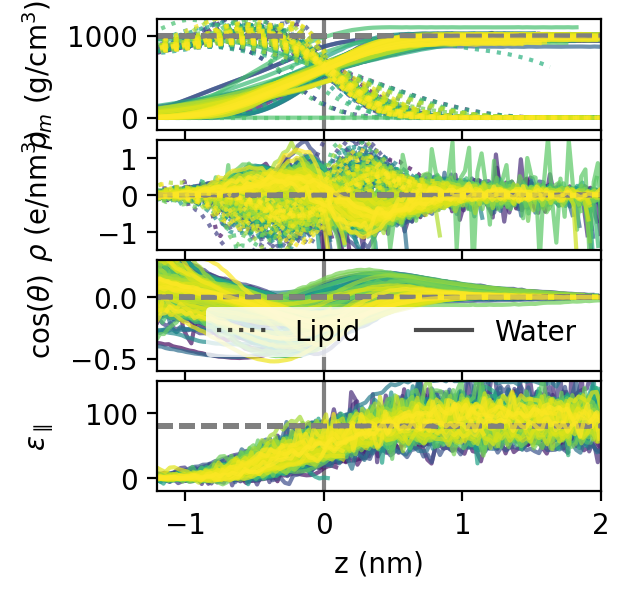

In [8]:
# select all PC lipids
sel = []
comp = []
for entry_id, entry_data in data_dict.items():
    if 'LipidMassDensity' not in entry_data:
        continue
    if np.array(entry_data['LipidMassDensity'])[:,1].max() > 2000: 
        continue
    if all("PC" in c for c in entry_data["constituents"]):
        sel.append(entry_id)
        comp.append(entry_data["constituents"])

plot_profiles(sel[:], fname="figures/pc_profiles.png")

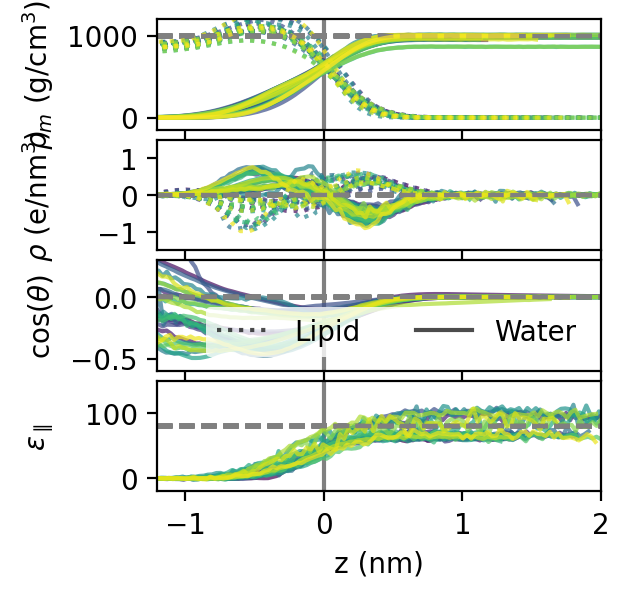

In [9]:
# select all PE lipids
sel = []
comp = []
for entry_id, entry_data in data_dict.items():
    if 'LipidMassDensity' not in entry_data:
        continue
    if np.array(entry_data['LipidMassDensity'])[:,1].max() > 2000: 
        continue
    if all("PE" in c for c in entry_data["constituents"]):
        sel.append(entry_id)
        comp.append(entry_data["constituents"])

plot_profiles(sel[:100], fname="figures/pe_profiles.png")

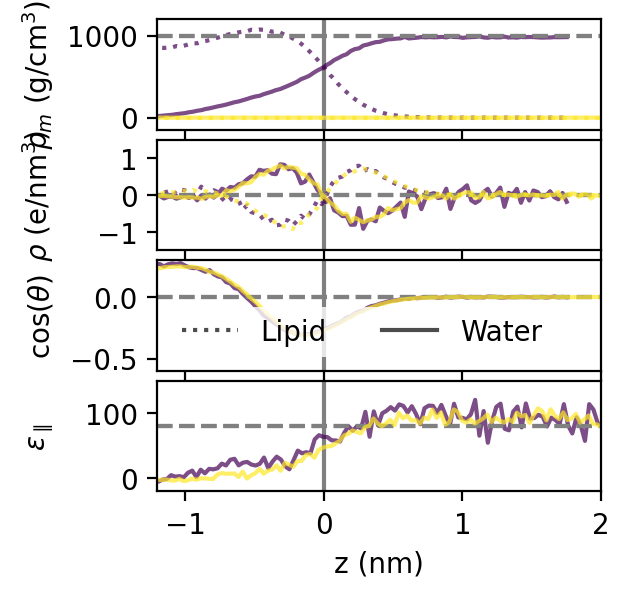

In [10]:
#select all SM lipids
sel = []
for entry_id, entry_data in data_dict.items():
    if all("SM" in c for c in entry_data["constituents"]):
        sel.append(entry_id)

plot_profiles(sel, fname="figures/sm_profiles.png")

# all neutral (PC, PE, CHOL, SM)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

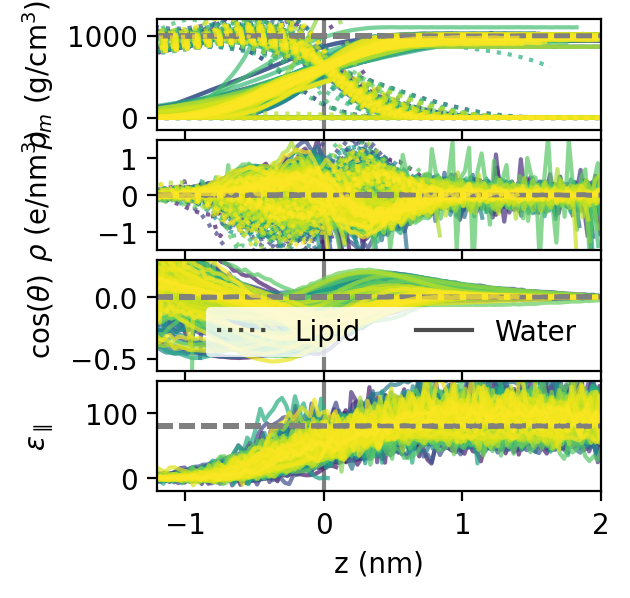

In [12]:
sel = []
for entry_id, entry_data in data_dict.items():
    bad = False
    for c in entry_data["constituents"]:
        if not (
            "SM" in c or
            "PC" in c or
            "PE" in c or 
            "CHOL" in c
        ):
            bad = True
            break
    if bad:
        continue
    sel.append(entry_id)

plot_profiles(sel, fname="figures/sm_profiles.png")

In [13]:
len(sel)

614

In [25]:
from fairmd.lipids.molecules import lipids_set
iontran = {
    'CLA': 'Cl',
    'SOD': 'Na',
    'POT': 'K',
    'CAL': 'Ca'
}
def get_ions(s):
    return set([iontran[i] for i in s.content if i != "SOL" and i not in lipids_set])
    

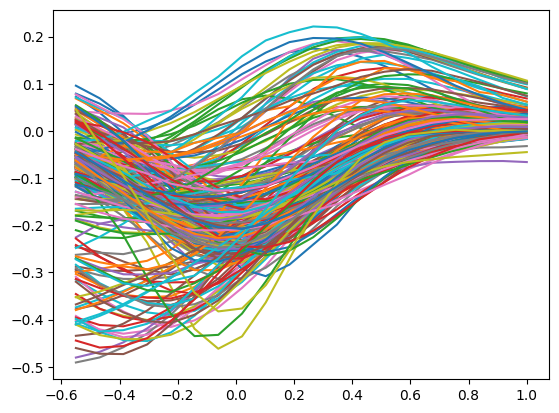

In [35]:
for_clustering = []

for s in sel:
    if 'DiporderWater' not in data_dict[s]:
        continue
    dat = data_dict[s]['DiporderWater']
    stx = dat[:,0].searchsorted(-0.6)
    enx = dat[:,0].searchsorted(+1.1)
    if enx == dat.shape[0] or stx == 0:
        continue # system too compact
    fu = interp1d(dat[stx:enx,0], dat[stx:enx,1])
    xx = np.linspace(-0.55,1,20)
    yy = fu(xx)
    dbs = databank.loc(s)
    #print(get_ions(dbs))
    if max(yy) > 2000:
        print(dbs)
        continue
    _yy = [ s ] + [ dbs["FF"] ] + [":".join(np.sort(data_dict[s]["constituents"]))] + [":".join(get_ions(dbs))] + yy.tolist()
    for_clustering.append(_yy)
    plt.plot(xx,yy)

plt.show()


In [36]:
df = (
    pd.DataFrame(for_clustering)
      .set_index(0)
      .rename_axis("id")
)
df.rename(columns={1:'ff', 2:'lip', 3:'ion'}, inplace=True)
df.head()

,ff,lip,ion,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
id,,,,,,,,,,,,,,,,,,,,,
630,CHARMM36,SOPC,,-0.029487,-0.069605,-0.104771,-0.146283,-0.178836,-0.209303,-0.240148,...,-0.150887,-0.122742,-0.077432,-0.044360,-0.027609,-0.015448,-0.006697,-0.004463,0.001496,-0.002353
319,CHARMM36,DPPC,,-0.071642,-0.108305,-0.146685,-0.189755,-0.221450,-0.253084,-0.264090,...,-0.162687,-0.118641,-0.081241,-0.050457,-0.025746,-0.013494,-0.002983,-0.001736,0.000555,0.000189
175,CHARMM36,DPPC,,-0.169331,-0.180989,-0.190123,-0.193556,-0.193255,-0.186779,-0.183100,...,-0.135718,-0.112833,-0.092910,-0.068683,-0.050233,-0.033353,-0.020443,-0.013403,-0.005699,-0.002321
397,Lipid14 for lipids and AMBER99SB-ILDN for ions,POPC,Na:Cl,0.025923,0.000730,-0.030848,-0.066261,-0.104395,-0.136653,-0.162140,...,-0.135387,-0.104888,-0.073275,-0.045200,-0.023413,-0.004890,0.004796,0.012009,0.014118,0.011806
602,GAFFlipid,POPC,,0.034924,-0.009566,-0.056279,-0.102446,-0.161845,-0.204528,-0.235089,...,-0.178886,-0.137443,-0.097087,-0.060930,-0.034483,-0.020198,-0.006352,-0.002841,-0.002873,0.001871


In [28]:
X  = df.loc[:,4:].values # no labels

X_scaled = StandardScaler().fit_transform(X)

# UMAP embedding
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
)
X_umap = reducer.fit_transform(X_scaled)

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)


/Users/peptid/Local_Documents/git_repos/Databank/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [29]:
# colorize lipids
cols = df.lip.copy()
cols.loc[:] = 'b'
cols.loc[df.lip.str.contains('PE')] = 'r'
cols.loc[df.lip.str.contains('CHOL')] = 'm'
#cols.values

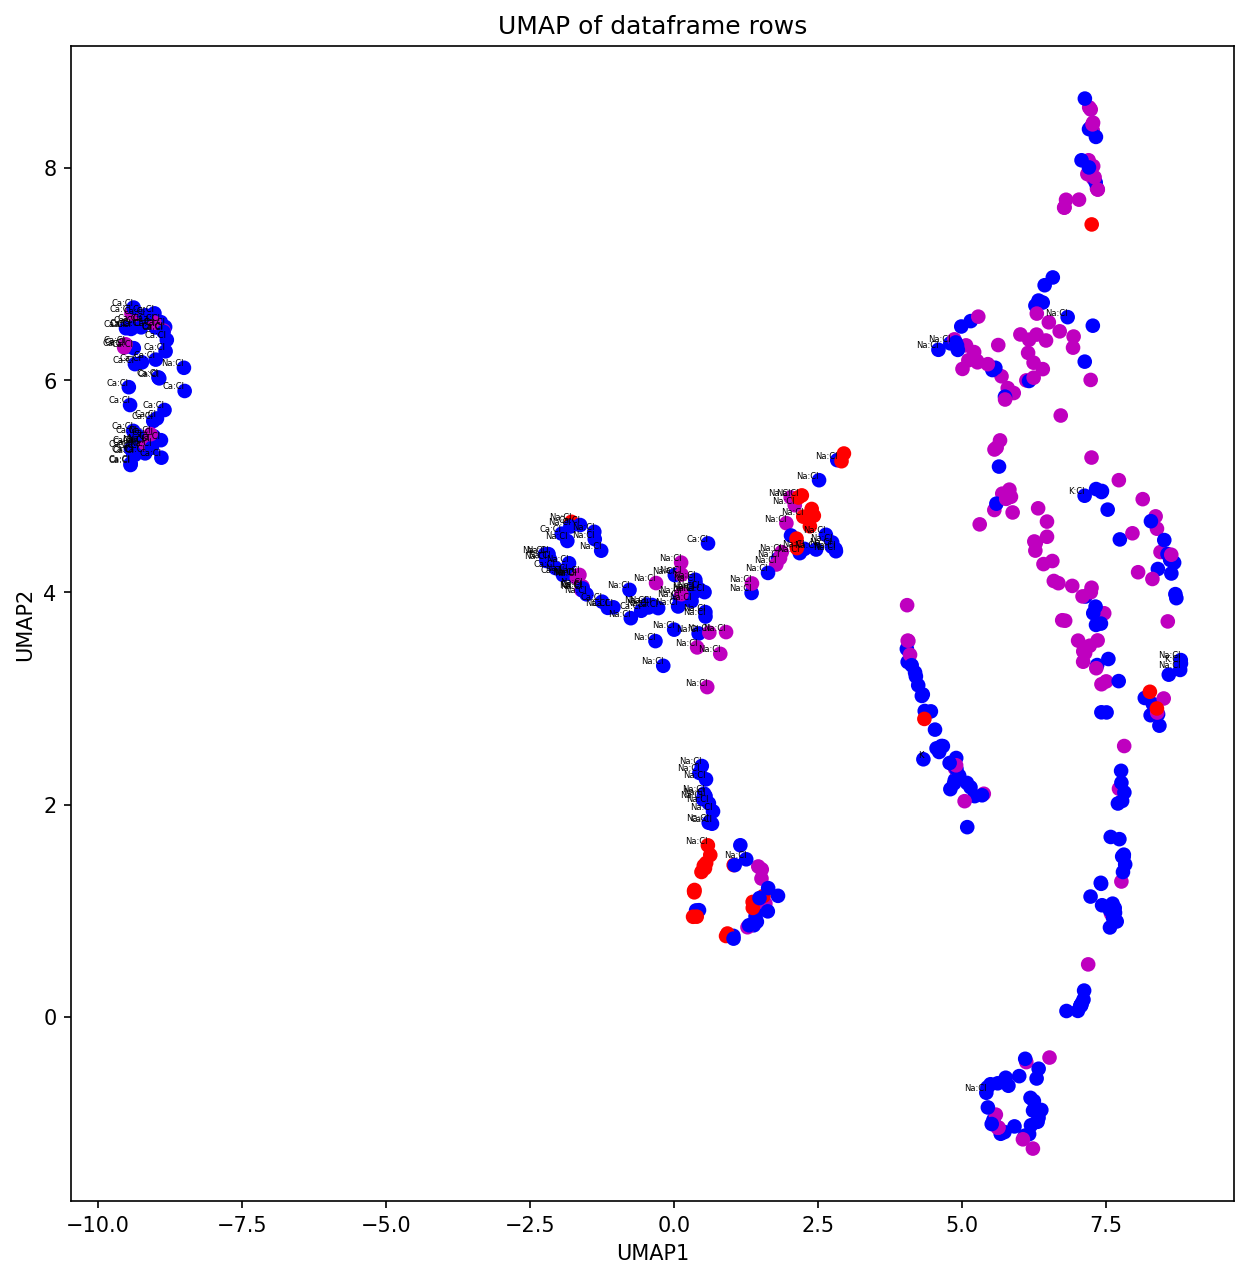

In [19]:
plt.figure(figsize=(10,10), dpi=150)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cols.values)

for i, label in enumerate(df.ion):
    plt.text(
        X_umap[i, 0],
        X_umap[i, 1],
        str(label),
        fontsize=4,
        ha="right",
        va="bottom"
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of dataframe rows")
plt.show()


## with leiden

In [38]:
import leidenalg
import igraph as ig
from sklearn.neighbors import kneighbors_graph

/Users/peptid/Local_Documents/git_repos/Databank/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


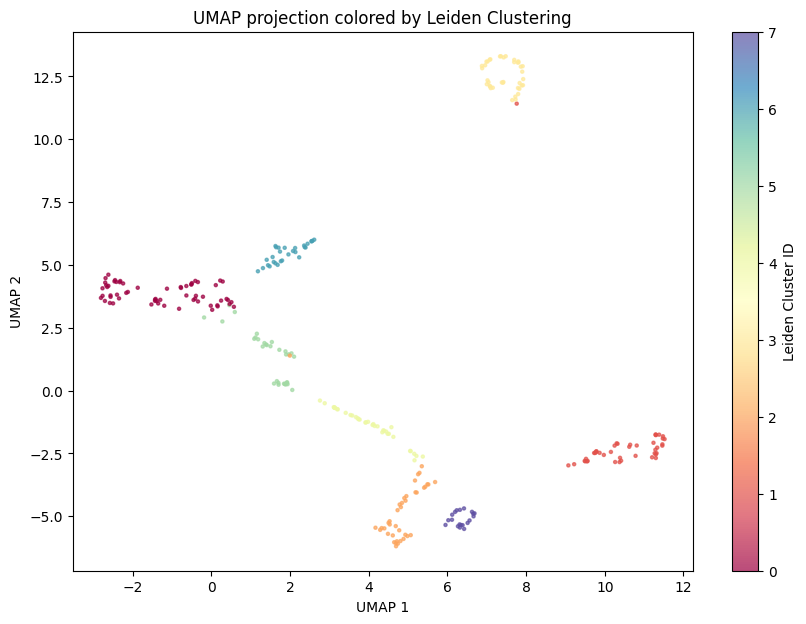

In [39]:
# 1. Assume 'df' is your dataframe
# Ensure only numerical data is used for clustering
data_for_clustering = df.select_dtypes(include=[np.number])

# 2. Compute UMAP Embeddings
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(data_for_clustering)

# 3. Create a Graph for Leiden
# Leiden operates on an adjacency matrix (graph)
connectivity = kneighbors_graph(data_for_clustering, n_neighbors=15, include_self=False)
sources, targets = connectivity.nonzero()
edgelist = list(zip(sources, targets))
g = ig.Graph(n=len(data_for_clustering), edges=edgelist)

# 4. Apply Leiden Clustering
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)
labels = np.array(partition.membership)

# 5. Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=labels, 
    cmap='Spectral', 
    s=5, 
    alpha=0.7
)

plt.colorbar(scatter, label='Leiden Cluster ID')
plt.title("UMAP projection colored by Leiden Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Critical for your LaTeX-less environment:
plt.rcParams["text.usetex"] = False 

plt.show()

In [40]:
df['leiden_cluster'] = labels

In [47]:
df[df['leiden_cluster']==0]

,ff,lip,ion,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,leiden_cluster
id,,,,,,,,,,,,,,,,,,,,,
319,CHARMM36,DPPC,,-0.071642,-0.108305,-0.146685,-0.189755,-0.221450,-0.253084,-0.264090,...,-0.118641,-0.081241,-0.050457,-0.025746,-0.013494,-0.002983,-0.001736,0.000555,0.000189,0
773,CHARMM36m,POPC,K:Cl,-0.078906,-0.109431,-0.143893,-0.174550,-0.201203,-0.219631,-0.227501,...,-0.106413,-0.073173,-0.044469,-0.022109,-0.006474,0.004510,0.009540,0.012312,0.013050,0
520,CHARMM36,DOPC,,-0.043323,-0.077625,-0.125310,-0.155264,-0.202792,-0.242385,-0.274850,...,-0.115294,-0.083879,-0.045589,-0.021394,-0.012678,-0.003071,-0.002855,0.002737,0.003551,0
808,CHARMM36,DMPC,,-0.079861,-0.114189,-0.149748,-0.182864,-0.211211,-0.232150,-0.240687,...,-0.122788,-0.088960,-0.060783,-0.038675,-0.022173,-0.011649,-0.006199,-0.001911,-0.000904,0
309,CHARMM36,DPPC,,-0.076153,-0.109700,-0.137268,-0.169932,-0.199159,-0.214551,-0.224231,...,-0.115381,-0.084881,-0.058692,-0.038027,-0.021671,-0.016121,-0.006285,-0.004723,0.000005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,C36_Slipids_Hybrid,POPC,,-0.039230,-0.076467,-0.114812,-0.163839,-0.209831,-0.249608,-0.270070,...,-0.113956,-0.076628,-0.046802,-0.024996,-0.011309,-0.004957,-0.000318,0.000222,-0.000348,0
623,CHARMM36,POPC,,-0.070633,-0.100654,-0.134898,-0.170459,-0.201760,-0.227575,-0.239618,...,-0.119173,-0.088341,-0.058380,-0.036910,-0.020337,-0.010838,-0.004806,-0.001257,-0.000956,0
205,CHARMM36,DPPC,,-0.063040,-0.098733,-0.131632,-0.166283,-0.195240,-0.218203,-0.226820,...,-0.117160,-0.084544,-0.058804,-0.036316,-0.022324,-0.011656,-0.005433,-0.001558,-0.001450,0


# Lipid charge density

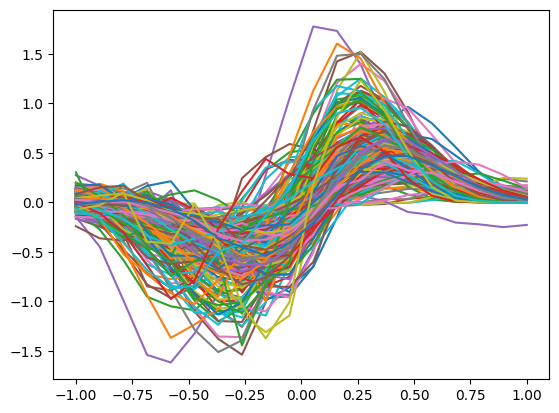

In [48]:
# select all PE lipids
sel = []
comp = []
for entry_id, entry_data in data_dict.items():
    if (
        'LipidMassDensity' not in entry_data or 
        np.array(entry_data['LipidMassDensity'])[:,1].max() > 2000
    ): 
        continue
    if (
        all("PE" in c for c in entry_data["constituents"]) or
        all("PC" in c for c in entry_data["constituents"]) 
    ):
        sel.append(entry_id)

from scipy.interpolate import interp1d

for_clustering = []

for s in sel:
    if 'LipidChargeDensity' not in data_dict[s]:
        continue
    dat = data_dict[s]['LipidChargeDensity']
    stx = dat[:,0].searchsorted(-1.1)
    enx = dat[:,0].searchsorted(+1.1)
    # print(enx, dat.shape[0])
    if enx == dat.shape[0] or stx == 0:
        continue
    fu = interp1d(dat[stx:enx,0], dat[stx:enx,1])
    xx = np.linspace(-1,1,20)
    yy = fu(xx)
    plt.plot(xx,yy)
    _yy = [ s ] + [ databank.loc(s)["FF"] ] + [ data_dict[s]["constituents"][0] ] + yy.tolist()
    for_clustering.append(_yy)

plt.show()


In [49]:
df = (
    pd.DataFrame(for_clustering)
      .set_index(0)
      .rename_axis("id")
)
df.rename(columns={1:'ff', 2:'lip'}, inplace=True)

In [50]:
X  = df.loc[:,3:].values # no labels

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [51]:
# colorize lipids
cols = df.lip.copy()
cols.loc[:] = 'b'
cols.loc[df.lip.str.contains('PE')] = 'r'
#cols.values

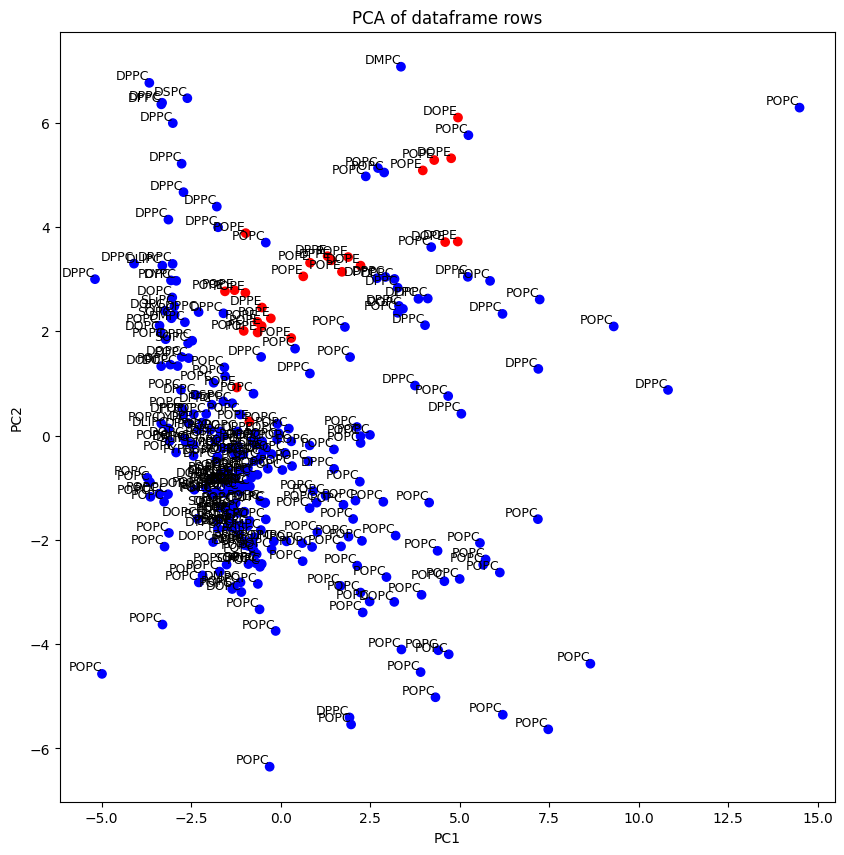

In [52]:
plt.figure(figsize=(10,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cols.values)

for i, label in enumerate(df.lip):
    plt.text(
        X_pca[i, 0],
        X_pca[i, 1],
        str(label),
        fontsize=9,
        ha="right",
        va="bottom"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of dataframe rows")
plt.show()


## with leiden

/Users/peptid/Local_Documents/git_repos/Databank/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


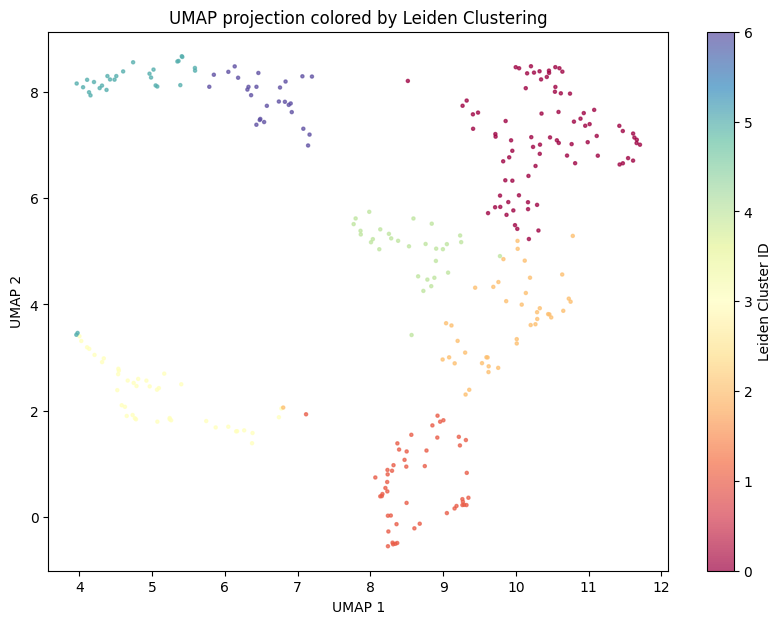

,ff,lip,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,leiden_cluster
id,,,,,,,,,,,,,,,,,,,,,
630,CHARMM36,SOPC,-0.022205,-0.034055,0.043542,0.077504,-0.067883,-0.136937,-0.439084,-0.587056,...,0.165564,0.528182,0.643368,0.576051,0.408442,0.222342,0.081177,0.016832,0.004624,0
319,CHARMM36,DPPC,0.046995,0.063881,0.046855,-0.055776,-0.038930,-0.518537,-0.413841,-0.722345,...,0.234469,0.565773,0.702977,0.649985,0.428388,0.199003,0.075015,0.019324,0.001595,0
602,GAFFlipid,POPC,0.158129,0.153830,0.035393,-0.076645,-0.206225,-0.347312,-0.452364,-0.616566,...,0.175420,0.540824,0.603174,0.529949,0.342998,0.171475,0.063745,0.019104,0.003236,0
632,CHARMM36,DYPC,0.024369,0.072625,0.057313,0.075396,-0.013389,-0.011510,-0.386142,-0.679544,...,0.235851,0.553987,0.617968,0.521118,0.412366,0.176642,0.073051,0.016299,0.003150,0
508,MacRog,POPC,-0.046631,-0.040629,0.049654,-0.092491,-0.039091,-0.269602,-0.360638,-0.749166,...,-0.154789,0.459814,0.812712,0.965442,0.800017,0.558441,0.306829,0.140743,0.048933,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,CHARMM36,POPC,-0.018724,0.013807,-0.022270,-0.023369,-0.130662,-0.310660,-0.491709,-0.595559,...,0.245519,0.497079,0.618078,0.550834,0.406930,0.252376,0.123709,0.053580,0.017054,0
831,C36_Slipids_Hybrid,POPC,0.083788,0.150807,0.169008,0.014239,-0.137538,-0.427427,-0.666326,-0.829127,...,0.352038,0.616466,0.724157,0.587383,0.394507,0.202064,0.076772,0.022637,0.003653,0
623,CHARMM36,POPC,0.001641,-0.012263,0.006288,-0.035656,-0.162550,-0.303265,-0.478555,-0.579617,...,0.197066,0.461491,0.578294,0.527864,0.410895,0.255970,0.130047,0.057428,0.016446,0


In [54]:
# 1. Assume 'df' is your dataframe
# Ensure only numerical data is used for clustering
data_for_clustering = df.select_dtypes(include=[np.number])

# 2. Compute UMAP Embeddings
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(data_for_clustering)

# 3. Create a Graph for Leiden
# Leiden operates on an adjacency matrix (graph)
connectivity = kneighbors_graph(data_for_clustering, n_neighbors=15, include_self=False)
sources, targets = connectivity.nonzero()
edgelist = list(zip(sources, targets))
g = ig.Graph(n=len(data_for_clustering), edges=edgelist)

# 4. Apply Leiden Clustering
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)
labels = np.array(partition.membership)

# 5. Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=labels, 
    cmap='Spectral', 
    s=5, 
    alpha=0.7
)

plt.colorbar(scatter, label='Leiden Cluster ID')
plt.title("UMAP projection colored by Leiden Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Critical for your LaTeX-less environment:
plt.rcParams["text.usetex"] = False 

plt.show()
df['leiden_cluster'] = labels
df[df['leiden_cluster']==0]